## Pytorch Workflow
![image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

In [20]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [21]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.5.1+cu121'

### 1. Data (preparing and loading)

In [22]:
# Create a linear data with *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias   # linear regression formula

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### 2. Split the data into train and test set
* One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

In [23]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [24]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=10, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=10, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

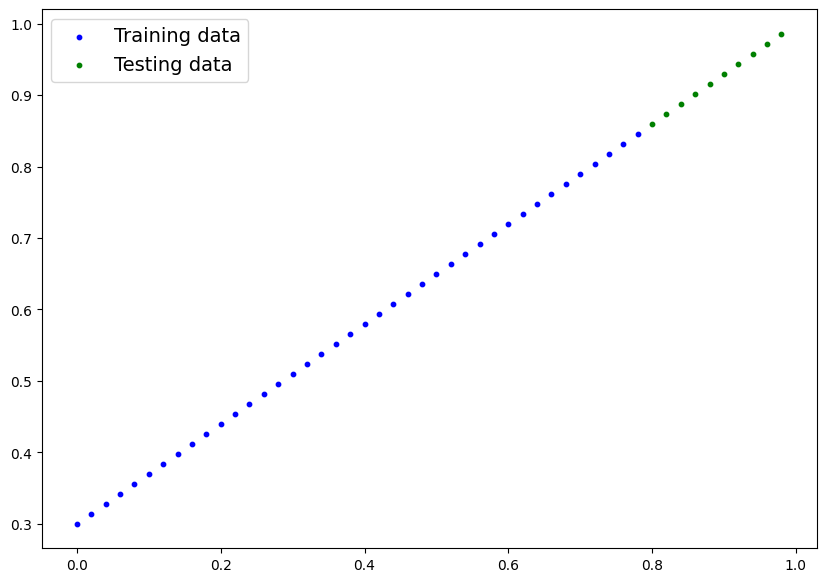

In [25]:
plot_predictions()

### 3. Build model
* Let's replicate a standard linear regression model using pure PyTorch.
* PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.
They are `torch.nn`, `torch.optim`, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`.



#### Pytorch Model building essentials
1. torch.nn -	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
2. torch.nn.Parameter	- Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
3. torch.nn.Module - The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
4. torch.optim - Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
5. def forward() - All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

In [26]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [27]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [28]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Making predictions using torch.inference_mode()   (without training the model)
* You probably noticed we used torch.inference_mode() as a context manager (that's what the with torch.inference_mode(): is) to make the predictions.

* As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

* torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

In [29]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [30]:
# Let see what we have predicted without training
print("Predictions shape : ", y_preds.shape)
print("Predictions : ", y_preds)

Predictions shape :  torch.Size([10, 1])
Predictions :  tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


In [31]:
print("Actual Labels : ", y_test)

Actual Labels :  tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])


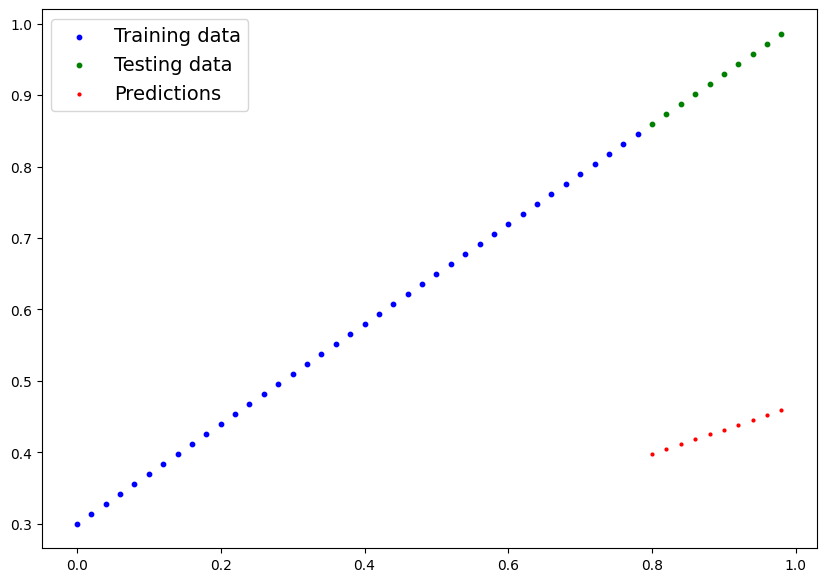

In [32]:
# Lets see what we have predicted
plot_predictions(predictions=y_preds)

* This makes sense though, when you remember our model is just using random parameter values to make predictions.

* It hasn't even looked at the blue dots to try to predict the green dots.

* So lets first train the model on training data and try to adjust the parameters so that it can predict the test data correctly

### 4. Training the model
* Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).
* To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

#### Creating a loss function and optimizer in PyTorch
* For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

* And that's a loss function as well as an optimizer.

* **Loss function**	: Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test).
    - Lower the better.
    -	PyTorch has plenty of built-in loss functions in torch.nn.	Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()). Binary cross entropy for binary classification problems (torch.nn.BCELoss()).
    - Otherwise we can define our own custom loss function.

* **Optimizer** : Tells your model how to update its internal parameters to best lower the loss.
  -	You can find various optimization function implementations in torch.optim.	Stochastic gradient descent (torch.optim.SGD()). Adam optimizer (torch.optim.Adam()). RMSprop optimizer (torch.optim.RMSprop())
  - Otherwise we can define our own custom optimization algorithm (generally its very rare).

In [33]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimizer
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

#### Creating an optimization loop in PyTorch
* The training loop involves the model going through the training data and learning the relationships between the features and labels.

* The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

* Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

#### For the training loop, we'll build the following steps:
1. **Forward pass** - The model goes through all of the training data once, performing its forward() function calculations.	model(x_train)
2. **Calculate the loss** - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.	loss = loss_fn(y_pred, y_train)
3. **Zero gradient** -	The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.	optimizer.zero_grad()
4. **Perform backpropagation on the loss** - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards".	loss.backward()
5. **Update the optimizer (gradient descent)** - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.	optimizer.step()

In [34]:
torch.manual_seed(42)
model = LinearRegressionModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

train_loss = []
test_loss = []
epoch_count = []

epochs = 100
for i in range(epochs):
    ### Training loop steps
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing loop steps
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        test_loss_value = loss_fn(y_pred, y_test)
        if i % 10 == 0:
            epoch_count.append(i)
            train_loss.append(loss.detach().numpy())
            test_loss.append(test_loss_value.detach().numpy())
            print(f"Epoch : {i} -- Train Loss = {loss} -- Test Loss = {test_loss_value}")

Epoch : 0 -- Train Loss = 0.31288138031959534 -- Test Loss = 0.48106518387794495
Epoch : 10 -- Train Loss = 0.1976713240146637 -- Test Loss = 0.3463551998138428
Epoch : 20 -- Train Loss = 0.08908725529909134 -- Test Loss = 0.21729660034179688
Epoch : 30 -- Train Loss = 0.053148526698350906 -- Test Loss = 0.14464017748832703
Epoch : 40 -- Train Loss = 0.04543796554207802 -- Test Loss = 0.11360953003168106
Epoch : 50 -- Train Loss = 0.04167863354086876 -- Test Loss = 0.09919948130846024
Epoch : 60 -- Train Loss = 0.03818932920694351 -- Test Loss = 0.08886633068323135
Epoch : 70 -- Train Loss = 0.03476089984178543 -- Test Loss = 0.0805937647819519
Epoch : 80 -- Train Loss = 0.03132382780313492 -- Test Loss = 0.07232122868299484
Epoch : 90 -- Train Loss = 0.02788739837706089 -- Test Loss = 0.06473556160926819


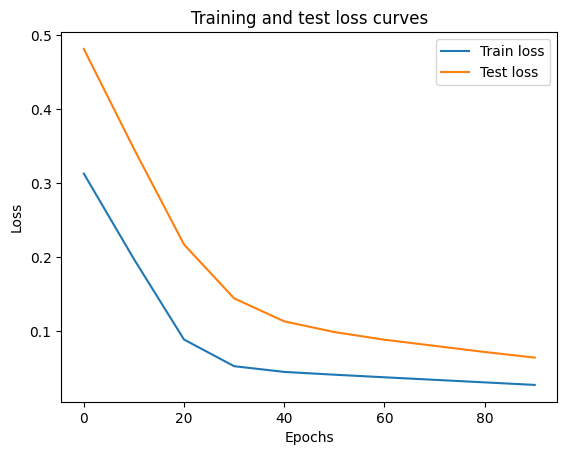

In [35]:
# Plot the loss curves
plt.plot(epoch_count, train_loss, label="Train loss")
plt.plot(epoch_count, test_loss, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [36]:
with torch.inference_mode():
    y_preds = model(y_test)
    print(y_preds)

tensor([[0.8488],
        [0.8569],
        [0.8650],
        [0.8731],
        [0.8812],
        [0.8893],
        [0.8974],
        [0.9055],
        [0.9136],
        [0.9217]])


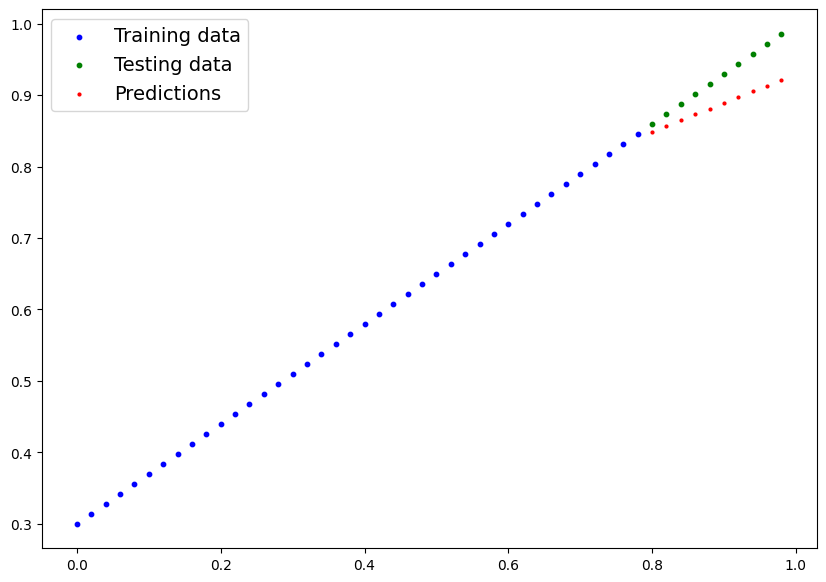

In [37]:
plot_predictions(predictions=y_preds.detach().numpy())

In [38]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 5. Saving and loading a PyTorch model
- If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

- As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

- Or maybe you'd like to save your progress on a model and come back and load it back later.

- For saving and loading models in PyTorch, there are three main methods you should be aware of:

1. **torch.save** - Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.
2. **torch.load** -	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).
3. **torch.nn.Module.load_state_dict** - Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [41]:
# saving the model's learned params
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


In [50]:
# Check the saved file path
!ls -lart models/01_pytorch_workflow_model.pth

-rw-r--r-- 1 root root 1668 Dec 12 13:58 models/01_pytorch_workflow_model.pth


In [51]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-51-aee3018a7a27>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

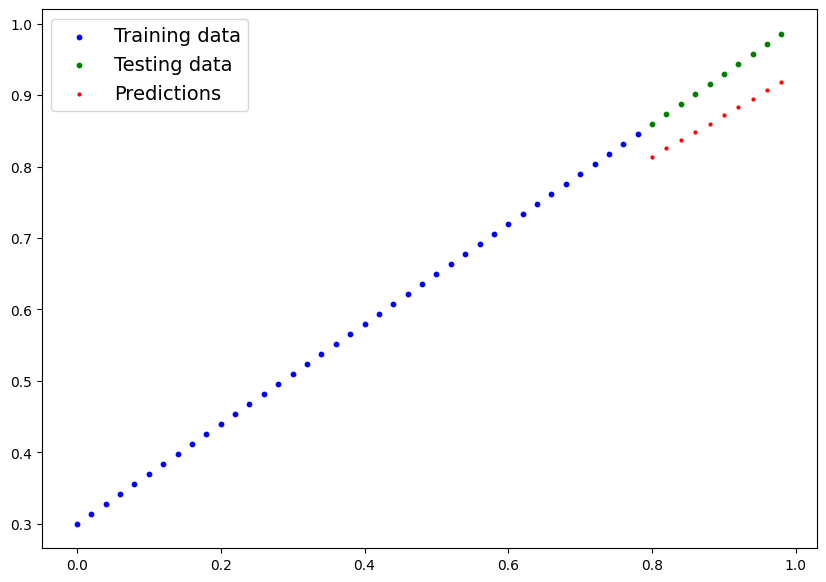

In [54]:
# Lets test the saved model
loaded_model.eval()
with torch.inference_mode():
    y_preds = loaded_model(X_test)

# Plot the predictions and the data
plot_predictions(predictions=y_preds)

### 6. Putting it all together


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.5.1+cu121'

In [3]:
# device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device : ", DEVICE)

Using device :  cuda


In [12]:
# Data preparation

# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [13]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [14]:
# Custom Plotting function
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=10, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=10, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

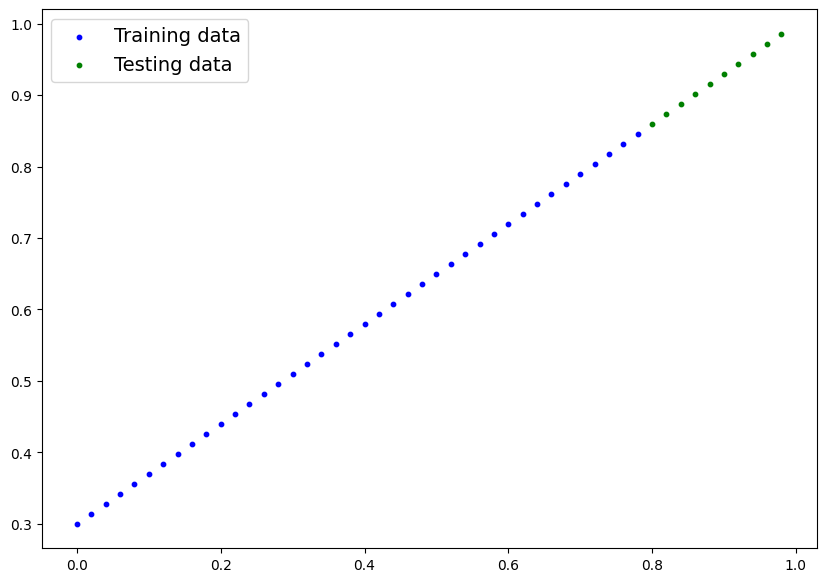

In [15]:
plot_predictions()

In [25]:
# Linear Regression model
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1,
                                      device=DEVICE)
    def forward(self, x):
        return self.linear_layer(x)


In [26]:
torch.manual_seed(42)
model = LinearRegression()
print("Model Parameters initially : ", model.state_dict())
print("Model device : ", next(model.parameters()).device)

Model Parameters initially :  OrderedDict([('linear_layer.weight', tensor([[0.2259]], device='cuda:0')), ('linear_layer.bias', tensor([0.9754], device='cuda:0'))])
Model device :  cuda:0


In [27]:
# Set the loss function and optimizers
loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [28]:
# Train the model before making predictions
torch.manual_seed(42)

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)
y_train = y_train.to(DEVICE)
y_test = y_test.to(DEVICE)

epochs = 1000
train_loss = []
test_loss = []
epoch_count = []

for i in range(epochs):
    # Training loop
    model.train()
    train_preds = model(X_train)
    loss = loss_function(y_train, train_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing loop
    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test)
        t_loss = loss_function(y_test, test_preds)
        if i % 100 == 0:
            train_loss.append(loss)
            test_loss.append(t_loss)
            epoch_count.append(i)
            print(f"Epoch : {i} | MAE Train Loss : {loss} | MAE Test Loss : {t_loss}")

Epoch : 0 | MAE Train Loss : 0.49054595828056335 | MAE Test Loss : 0.240034818649292
Epoch : 100 | MAE Train Loss : 0.10459736734628677 | MAE Test Loss : 0.240459606051445
Epoch : 200 | MAE Train Loss : 0.07017435133457184 | MAE Test Loss : 0.163229838013649
Epoch : 300 | MAE Train Loss : 0.03582926094532013 | MAE Test Loss : 0.08325198292732239
Epoch : 400 | MAE Train Loss : 0.0014897867804393172 | MAE Test Loss : 0.001909232116304338
Epoch : 500 | MAE Train Loss : 0.002532674465328455 | MAE Test Loss : 0.008408838883042336
Epoch : 600 | MAE Train Loss : 0.002532674465328455 | MAE Test Loss : 0.008408838883042336
Epoch : 700 | MAE Train Loss : 0.002532674465328455 | MAE Test Loss : 0.008408838883042336
Epoch : 800 | MAE Train Loss : 0.002532674465328455 | MAE Test Loss : 0.008408838883042336
Epoch : 900 | MAE Train Loss : 0.002532674465328455 | MAE Test Loss : 0.008408838883042336


In [29]:
print("Model Parameters after training : ", model.state_dict())

Model Parameters after training :  OrderedDict([('linear_layer.weight', tensor([[0.6949]], device='cuda:0')), ('linear_layer.bias', tensor([0.2994], device='cuda:0'))])


In [36]:
# Difference in between the learned and original "known" parameters
print("Weight diff : ", weight - model.state_dict()['linear_layer.weight'])
print("Weight diff : ", bias - model.state_dict()['linear_layer.bias'])

Weight diff :  tensor([[0.0051]], device='cuda:0')
Weight diff :  tensor([0.0006], device='cuda:0')


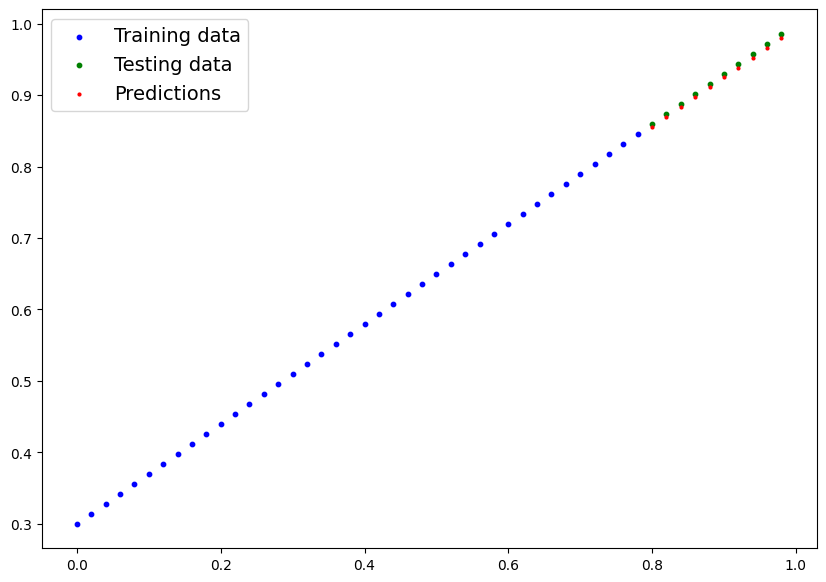

In [38]:
# Lets make predictions now
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)
plot_predictions(predictions=y_preds.cpu())

In [41]:
# Saving the model
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Final-model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the learned parameters
print("Saving the model to : ", MODEL_SAVE_PATH)
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving the model to :  models/Final-model.pth


In [42]:
# Loading the model
loaded_model = LinearRegression()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(DEVICE)

<ipython-input-42-ebc6c6e321a4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegression(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [43]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

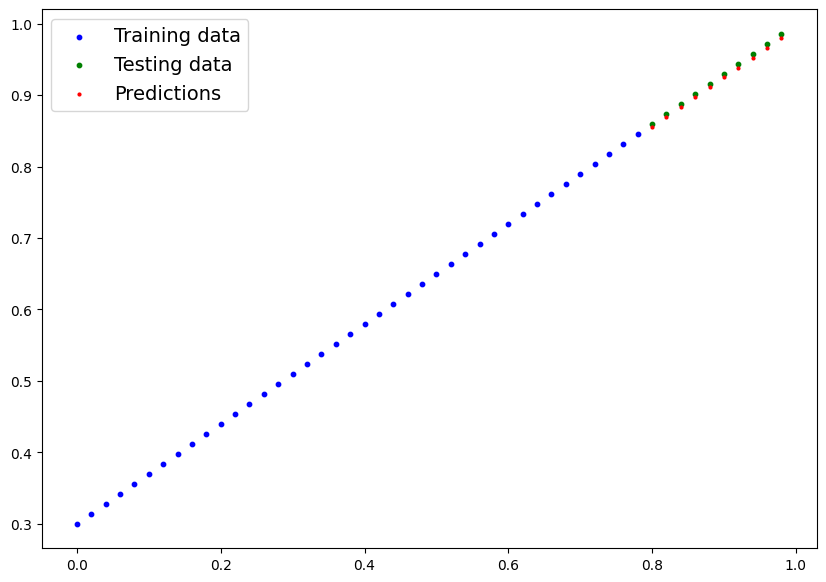

In [45]:
plot_predictions(predictions=loaded_model_preds.cpu())

### Final : What we achieved ?
* Perfect alignment of predictions with the test data
* Learned Fundamentals of Pytorch model building